In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from typing import Tuple


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv(r"C:\Users\Alberto\Desktop\Zrive\zrive-ds\Data set_Modulo2\feature_frame.csv")

In [45]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [88]:
info_cols = ["variant_id","order_id","user_id","created_at","order_at"]
label_col= "outcome"
features_cols = [col for col in df.columns if col not in info_cols + [label_col]]

categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]
numerical_cols =  [
    col for col in features_cols if col not in categorical_cols + binary_cols]

In [107]:
info_cols = ["variant_id", "order_id", "user_id", "created_at", "order_date"]
label_col = "outcome"
features_cols = [col for col in df.columns if col not in info_cols + [label_col]]

categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]
numerical_cols = [
    col for col in features_cols if col not in categorical_cols + binary_cols
]


In [108]:
def push_relevant_dataframe(df: pd.DataFrame, min_products: int = 5) -> pd.DataFrame:
    """Only interested in order that have more than 5 products"""
    order_size = df.groupby("order_id").outcome.sum()
    order_of_min_size = order_size[order_size>= min_products].index
    return df.loc[lambda x: x.order_id.isin(order_of_min_size)]

df_selected= (
    df.pipe(push_relevant_dataframe)
    .assign(created_at=lambda x: pd.to_datetime(x.created_at))
    .assign(order_date= lambda x: pd.to_datetime(x.order_date).dt.date)
)

In [109]:
df_selected.dtypes

variant_id                                   int64
product_type                                object
order_id                                     int64
user_id                                      int64
created_at                          datetime64[ns]
order_date                                  object
user_order_seq                               int64
outcome                                    float64
ordered_before                             float64
abandoned_before                           float64
active_snoozed                             float64
set_as_regular                             float64
normalised_price                           float64
discount_pct                               float64
vendor                                      object
global_popularity                          float64
count_adults                               float64
count_children                             float64
count_babies                               float64
count_pets                     

In [110]:
df.order_id.nunique() > df_selected.order_id.nunique()

True

In [111]:
df_selected.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [112]:
daily_orders = df_selected.groupby("order_date")
daily_orders.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11768,33667302359172,cleaningaccessories,2882526707844,3852411207812,2020-12-26 09:47:59,2020-12-26,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,36.0,27.986674,30.0,35.0,29.001400
14128,33667206283396,fabricconditionerfreshener,2814262542468,3763888685188,2020-10-10 20:52:08,2020-10-10,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,48.0,31.431177,30.0,36.0,28.588469
15212,33667206283396,fabricconditionerfreshener,2881475543172,3478277488772,2020-12-24 09:44:20,2020-12-24,8,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,48.0,31.431177,30.0,36.0,28.588469
18273,34368927957124,coffee,2881475543172,3478277488772,2020-12-24 09:44:20,2020-12-24,8,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,33.0,22.013658,30.0,31.0,24.363052


In [113]:
daily_orders = df_selected.groupby("order_date").order_id
daily_orders.head()

0        2807985930372
1        2808027644036
2        2808099078276
3        2808393957508
5        2808434524292
             ...      
11768    2882526707844
14128    2814262542468
15212    2881475543172
18273    2881475543172
23348    2814262542468
Name: order_id, Length: 745, dtype: int64

In [114]:
daily_orders = df_selected.groupby("order_date").order_id.nunique()

In [115]:
daily_orders.head()

order_date
2020-10-05     3
2020-10-06     7
2020-10-07     6
2020-10-08    12
2020-10-09     4
Name: order_id, dtype: int64

Text(0.5, 1.0, 'Daily Orders')

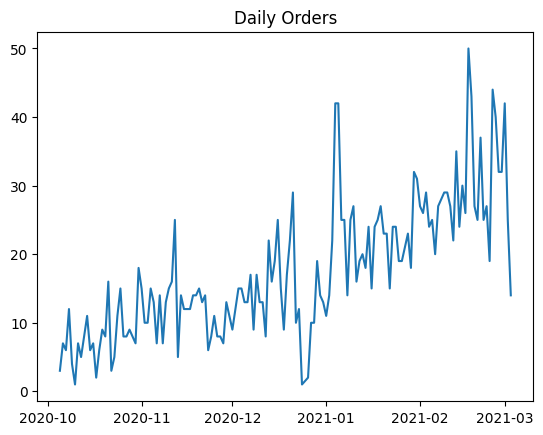

In [116]:
plt.plot(daily_orders, label = "daily orders")
plt.title("Daily Orders")

Evolution temporal fuerte ==> Interesante hacer un split temporal, sobre todo para evitar information leakage:

In [117]:
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()
cumsum_daily_orders

order_date
2020-10-05    0.001153
2020-10-06    0.003842
2020-10-07    0.006147
2020-10-08    0.010757
2020-10-09    0.012294
                ...   
2021-02-27    0.956589
2021-02-28    0.968882
2021-03-01    0.985017
2021-03-02    0.994622
2021-03-03    1.000000
Name: order_id, Length: 149, dtype: float64

In [118]:
train_val_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.7].idxmax()
val_test_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.9].idxmax()

print("Start:",cumsum_daily_orders.index.min())
print("End train:",train_val_cutoff)
print("End val:",val_test_cutoff)
print("End:",cumsum_daily_orders.index.max())

Start: 2020-10-05
End train: 2021-02-04
End val: 2021-02-22
End: 2021-03-03


In [119]:
train_df = df_selected[df_selected.order_date <= train_val_cutoff]
val_df = df_selected[
    (df_selected.order_date > train_val_cutoff)
    & (df_selected.order_date <= val_test_cutoff)
]
test_df = df_selected[df_selected.order_date > val_test_cutoff]

# Baseline 

Use variable global popularity to predict the posibility of buying a product.

I am going to use 2 metrics ==> Precion-Recall and ROC curve

In [120]:
def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        target_precision: float = 0.05,
        figure: Tuple[matplotlib.figure.Figure, np.array] = None,
        
): 
        precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
        pr_auc = auc(recall_, precision_)

        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)

        if figure is None:
                fig, ax = plt.subplots(1, 2, figsize = (14,7))
        else:
                fig, ax = figure

        ax[0].plot(recall_, precision_, label= f"{model_name}; AUC: {pr_auc:2f}")
        ax[0].set_xlabel("recall")
        ax[0].set_ylabel("precision")
        ax[0].set_title(f"Precision-recall Curve")
        ax[0].legend()

        ax[1].plot(fpr,tpr, label=f"{model_name}; AUC: {roc_auc:.2f}")
        ax[1].set_xlabel("FPR")
        ax[1].set_ylabel("TPR")
        ax[1].set_title(f"ROC Curve")
        ax[1].legend()



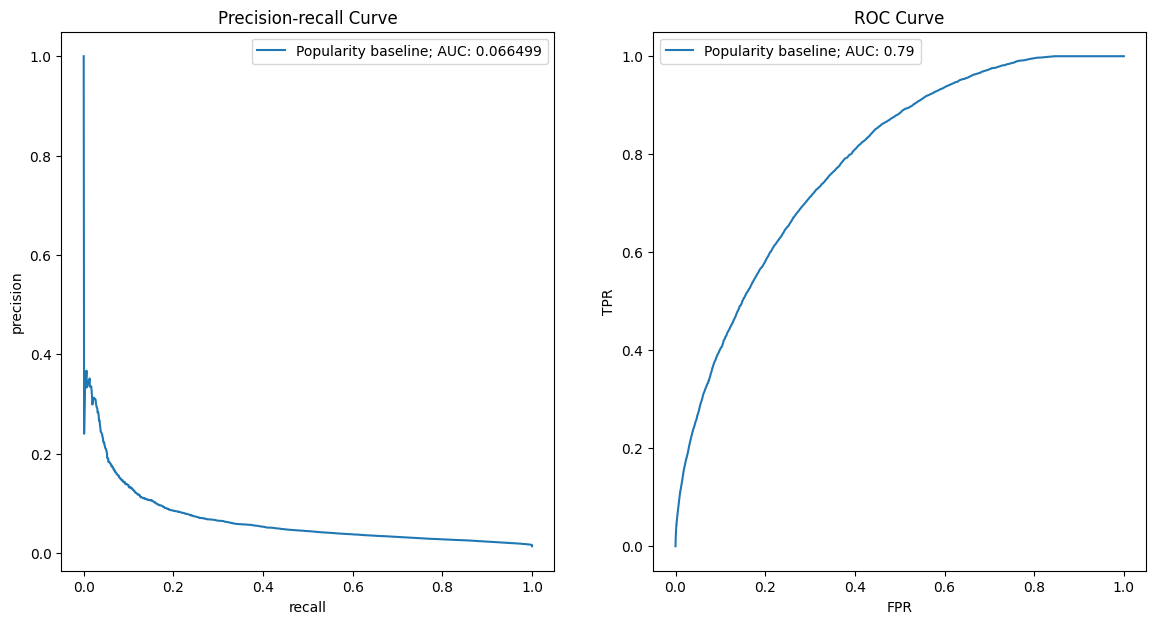

In [121]:
plot_metrics(
    "Popularity baseline", y_pred= val_df["global_popularity"], y_test = val_df[label_col]
)

Model Training!!!!

In [122]:
def features_label_split(
        df: pd.DataFrame, label_col: str
) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = features_label_split(train_df, label_col)
X_val, y_val = features_label_split(val_df, label_col)
X_test, y_test = features_label_split(test_df, label_col)

In [123]:
train_cols = numerical_cols + binary_cols

# Ridge Regression

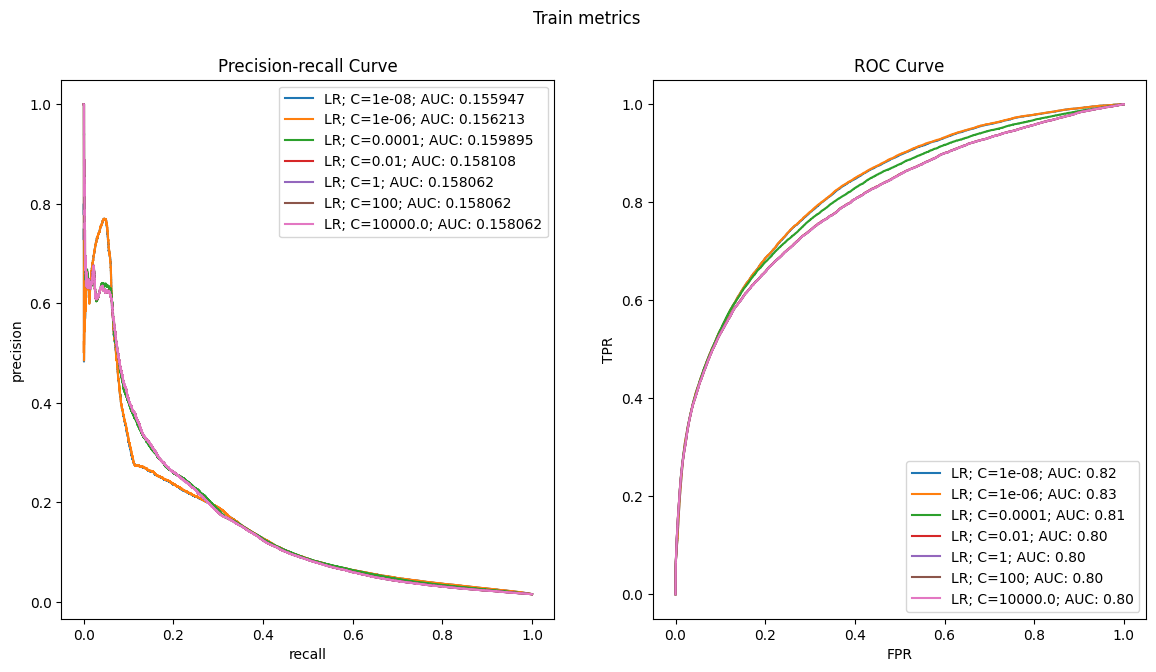

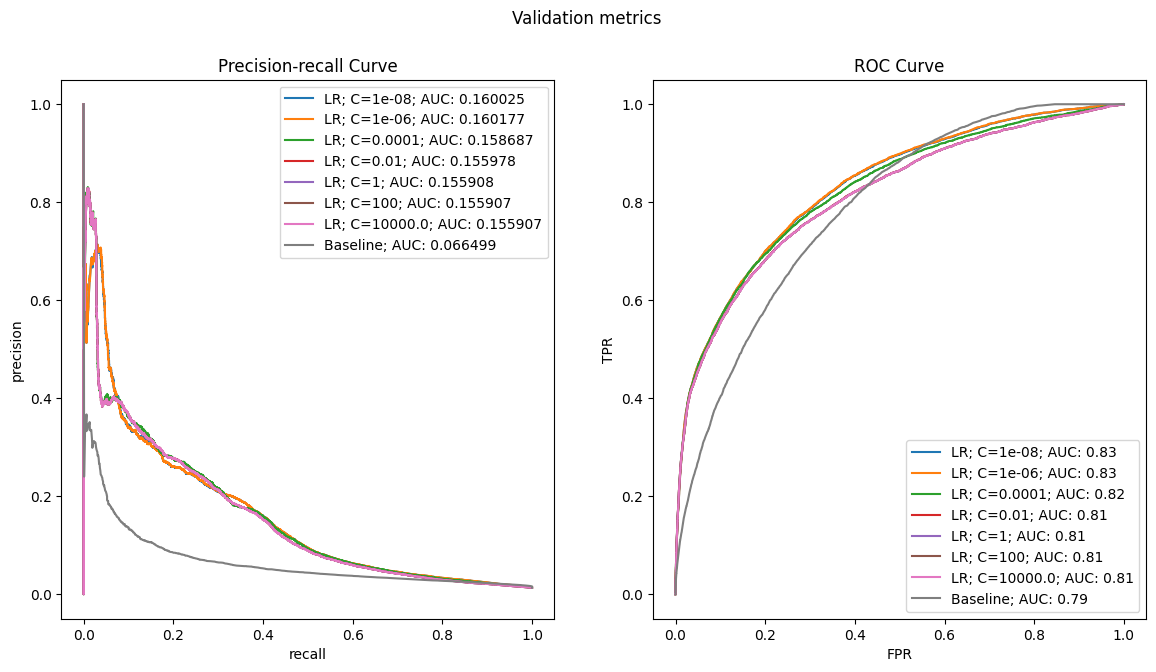

In [126]:
lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []

fig1, ax1 = plt.subplots(1, 2, figsize =(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize = (14, 7))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty= "l2", C = c if c else 1.0),
    )
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:,1]
    plot_metrics(
        f"LR; C={c}", y_pred = train_proba, y_test = train_df[label_col], figure = (fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
    )

plot_metrics(
    f"Baseline",
    y_pred= val_df["global_popularity"],
    y_test= val_df[label_col],
    figure=(fig2, ax2),
)




Almost same erros in train and validation so seems not to have overfitting

Large regularization seems to be better than small, even it didn't represent a big change


# Lasso Regression

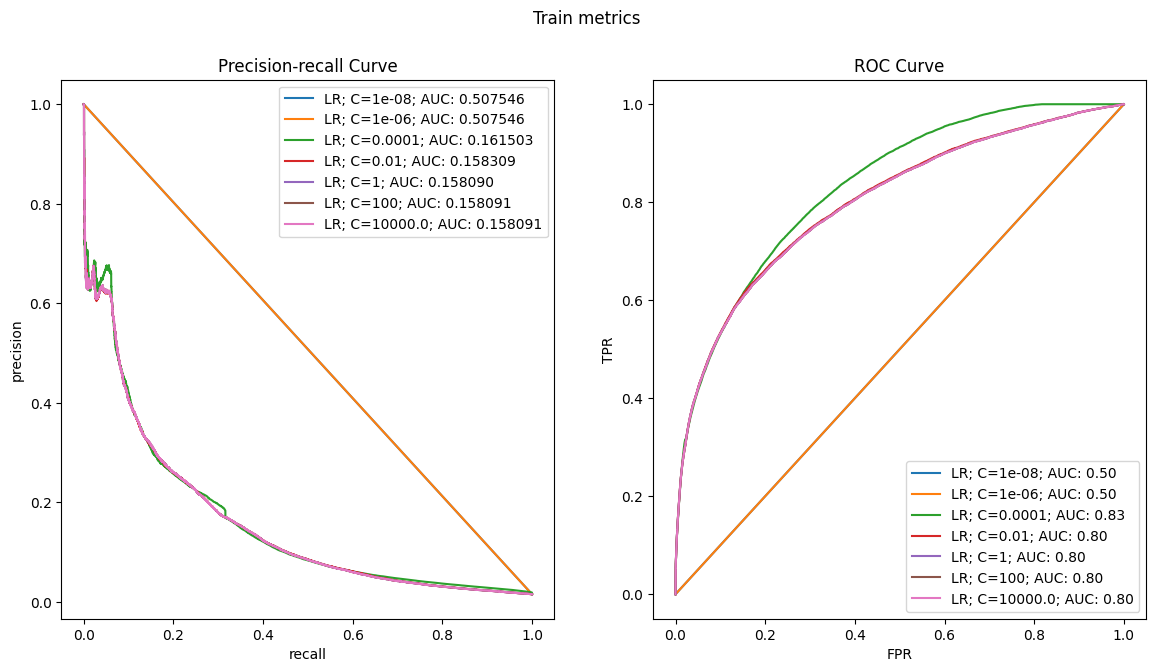

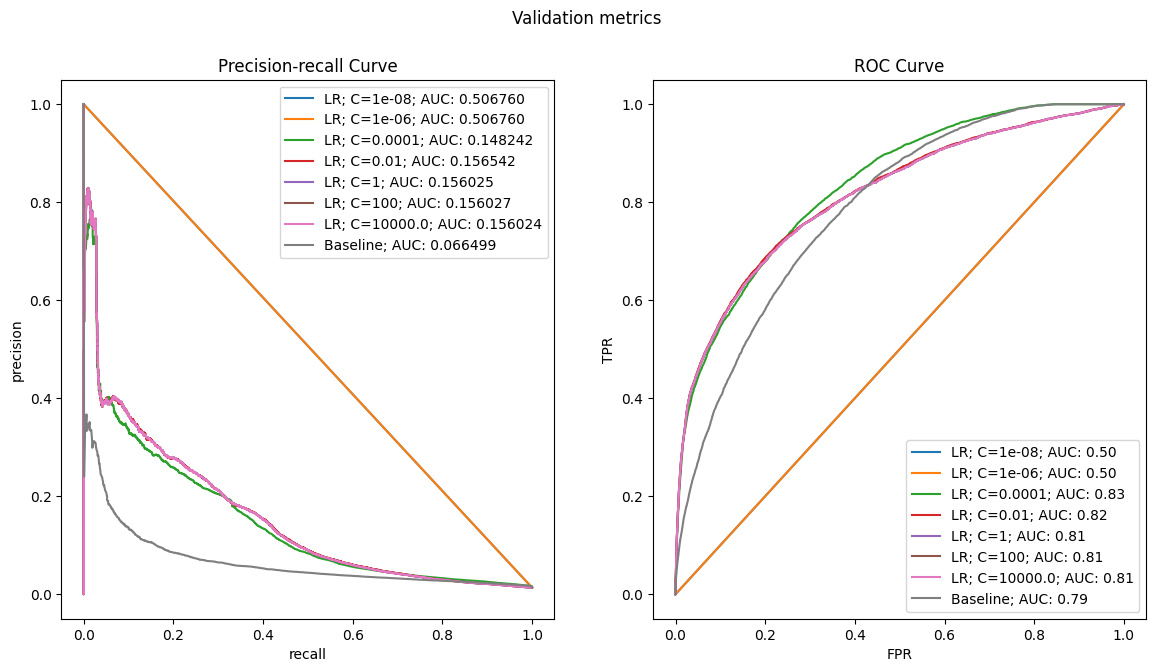

In [127]:
lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []

fig1, ax1 = plt.subplots(1, 2, figsize =(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize = (14, 7))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4]
for c in cs:
    lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty= "l1", C = c if c else 1.0, solver = "saga"),
    )
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:,1]
    plot_metrics(
        f"LR; C={c}", y_pred = train_proba, y_test = train_df[label_col], figure = (fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test= val_df[label_col], figure=(fig2, ax2)
    )

plot_metrics(
    f"Baseline",
    y_pred= val_df["global_popularity"],
    y_test= val_df[label_col],
    figure=(fig2, ax2),
)


Large regularisation make the model working as random. Precision recall only have 2 points in the curve, 0 or 1 so it is wrong.

Letting this apart, regularisation doesn't seem to make an impact

Similar performance as Ridge

# Coefficients weights

In [132]:
lr = Pipeline(
    [
        ("standar_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l2", C=1e-6)),
    ]
)
lr.fit(X_train[train_cols], y_train)
lr_coeff_l2= pd.DataFrame(
    {
        "features": train_cols,
        "importance": np.abs(lr.named_steps["lr"].coef_[0]),
        "regularisation": ["l2"]* len(train_cols),
    }
)
lr_coeff_l2 = lr_coeff_l2.sort_values("importance", ascending=True)

lr = Pipeline(
    [
        ("standar_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l1", C=1e-4, solver="saga")),
    ]
)
lr.fit(X_train[train_cols], y_train)
lr_coeff_l1= pd.DataFrame(
    {
        "features": train_cols,
        "importance": np.abs(lr.named_steps["lr"].coef_[0]),
        "regularisation": "l1",
    }
)
lr_coeff_l1 = lr_coeff_l1.sort_values("importance", ascending=True)

<Axes: xlabel='importance', ylabel='features'>

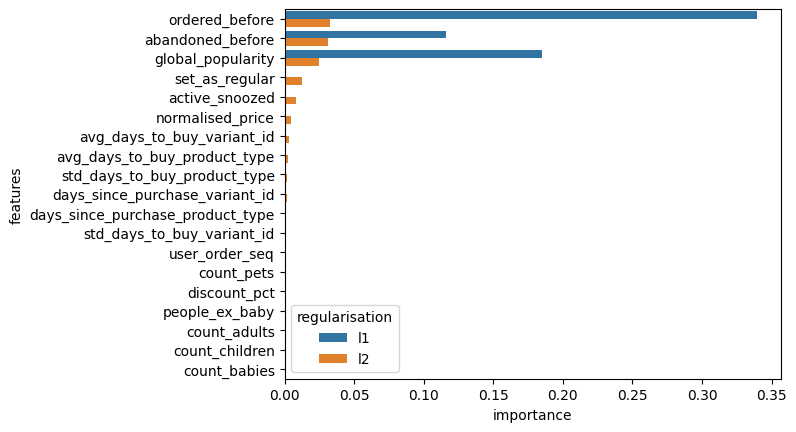

In [134]:
lr_coeffs = pd.concat([lr_coeff_l2, lr_coeff_l1])
lr_coeffs["features"] = pd.Categorical(lr_coeffs["features"])
lr_coeffs = lr_coeffs.sort_values(by = ["importance"])
order_columns = lr_coeff_l2.sort_values(by="importance", ascending=False)["features"]
sns.barplot(
    data = lr_coeffs,
    x= "importance",
    y = "features",
    hue= "regularisation",
    order = order_columns,
)

### Train new model only with the first 3 features

In [135]:
reduced_cols = ["ordered_before", "abandoned_before", "global_popularity"]

Ridge regresion

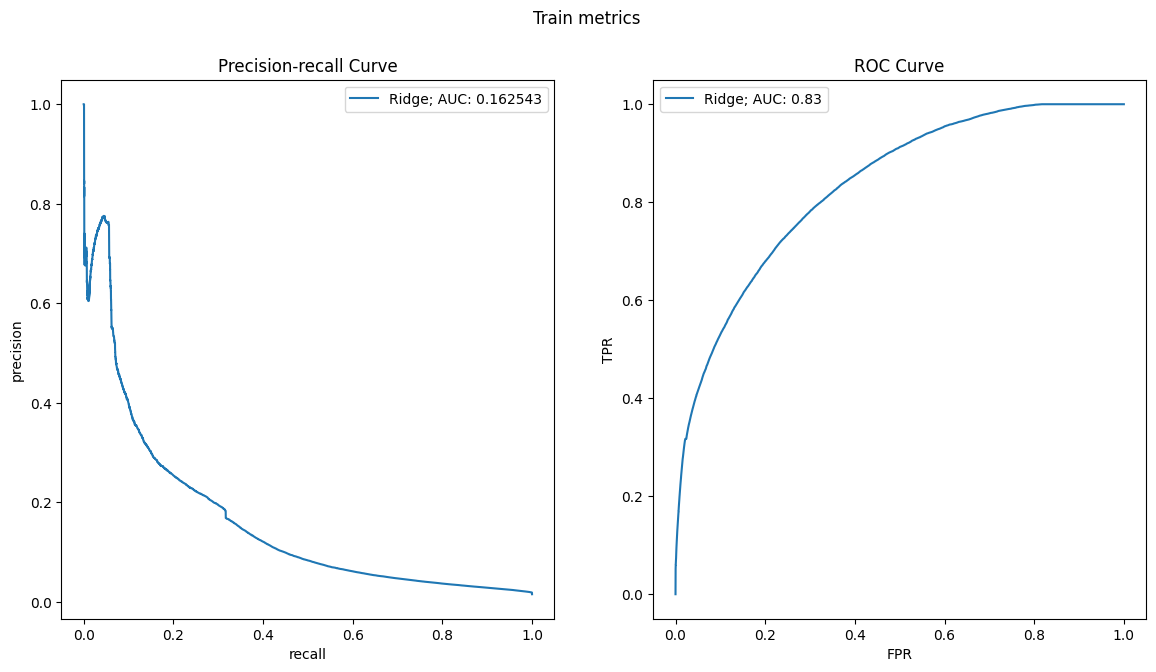

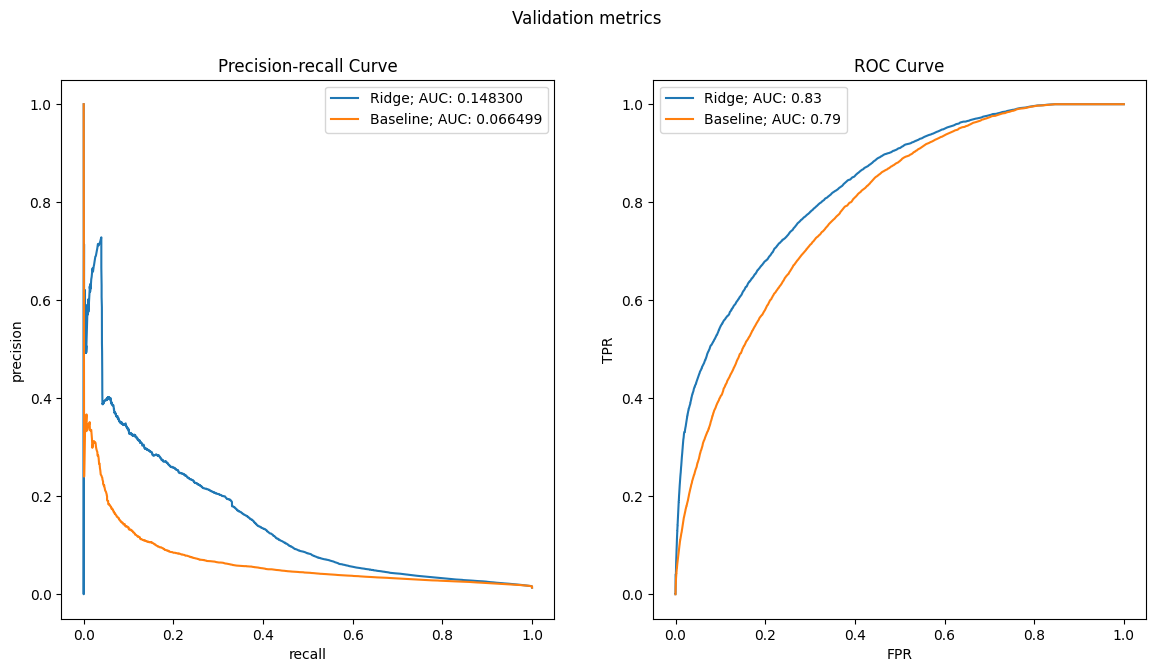

In [142]:
fig1, ax1 = plt.subplots(1, 2, figsize =(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize = (14, 7))
fig2.suptitle("Validation metrics")

lr2 = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty= "l2", C = 1e-6),
)
lr2.fit(X_train[reduced_cols], y_train)
train_proba = lr2.predict_proba(X_train[reduced_cols])[:,1]

plot_metrics(
    f"Ridge", y_pred = train_proba, y_test = train_df[label_col], figure = (fig1, ax1)
)

val_proba = lr2.predict_proba(X_val[reduced_cols])[:, 1]

plot_metrics(
    f"Ridge", y_pred=val_proba, y_test= val_df[label_col], figure = (fig2, ax2)
)

plot_metrics(
    f"Baseline",
    y_pred= val_df["global_popularity"],
    y_test= val_df[label_col],
    figure=(fig2, ax2),
)

Lasso Regression

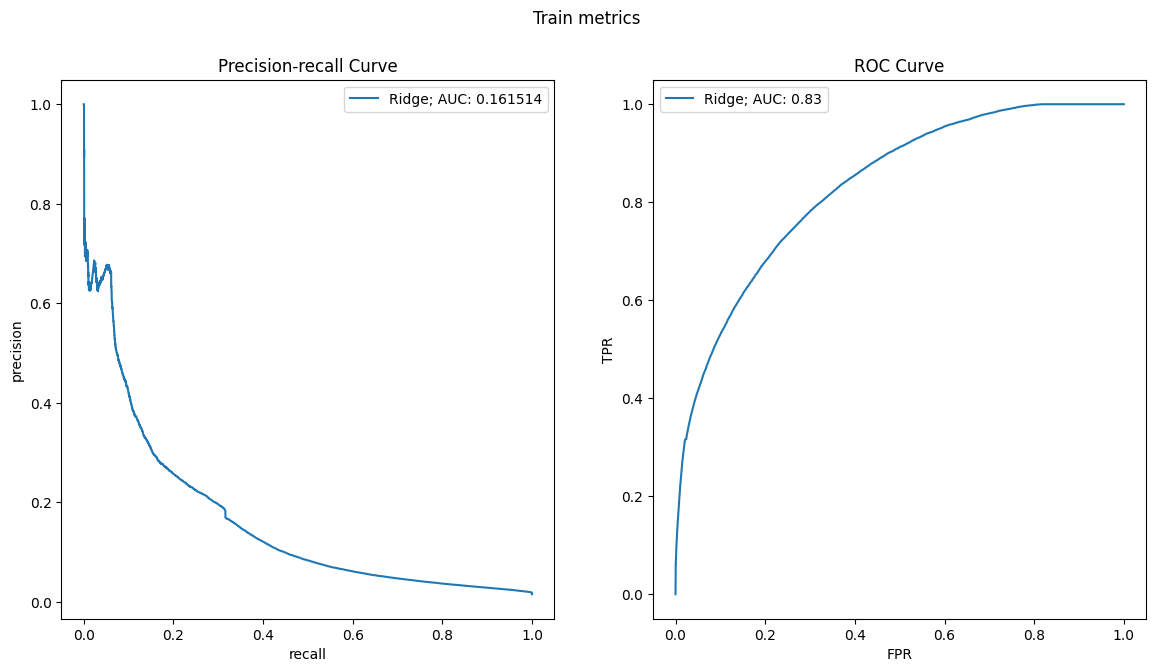

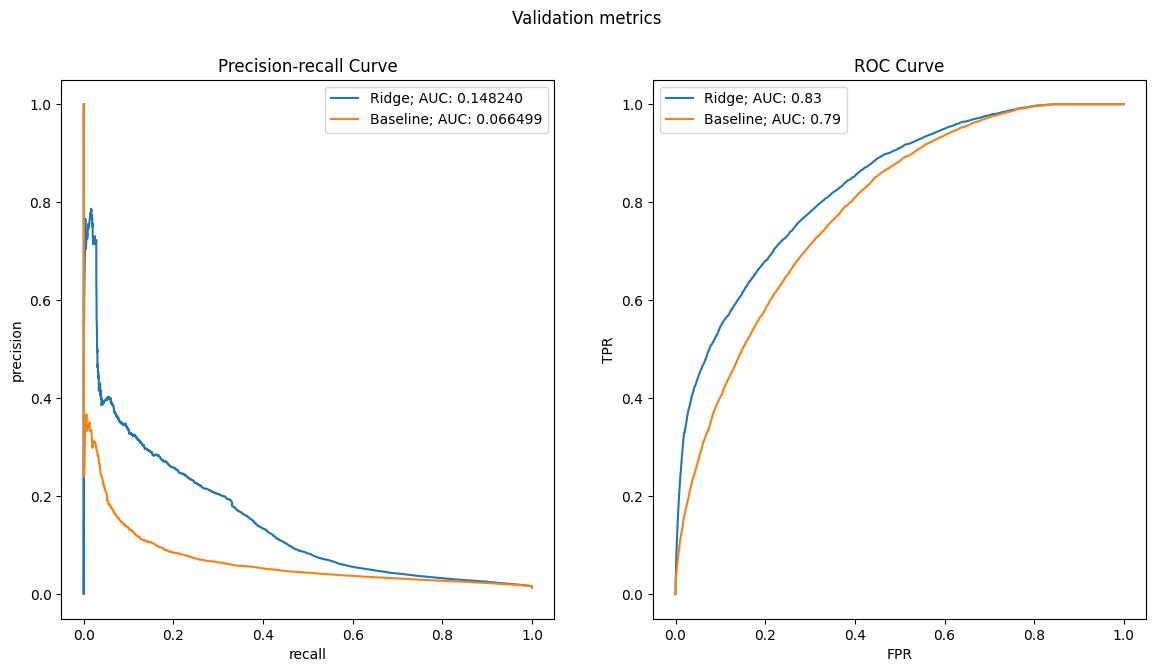

In [145]:
fig1, ax1 = plt.subplots(1, 2, figsize =(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize = (14, 7))
fig2.suptitle("Validation metrics")

lr2 = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty= "l1", C = 1e-4, solver="saga"),
)
lr2.fit(X_train[reduced_cols], y_train)
train_proba = lr2.predict_proba(X_train[reduced_cols])[:,1]

plot_metrics(
    f"Ridge", y_pred = train_proba, y_test = train_df[label_col], figure = (fig1, ax1)
)

val_proba = lr2.predict_proba(X_val[reduced_cols])[:, 1]

plot_metrics(
    f"Ridge", y_pred=val_proba, y_test= val_df[label_col], figure = (fig2, ax2)
)

plot_metrics(
    f"Baseline",
    y_pred= val_df["global_popularity"],
    y_test= val_df[label_col],
    figure=(fig2, ax2),
)

## Results

Ridge and lasso are better than the baseline